In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import xarray as xr
logger = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})

[ruth-macbook.whoi.edu:21375] shmem: mmap: an error occurred while determining whether or not /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T//ompi.ruth-macbook.503/jf.0/2599485440/sm_segment.ruth-macbook.503.9af10000.0 could be created.


Here the time dependendent IVP problem we're looking to iterate starts from the following
$$ \nabla\cdot\Big(\frac{1}{h}\nabla\frac{\partial \psi}{\partial t}\Big)+f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = \underbrace{-\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)}_{\text{dissipation}}+\underbrace{w_{Ek}\exp(ift \omega_\textrm{force})}_{\text{forcing}}$$
which is the system considered previously with no assumed form to the temporal dependence (no ansatz) and the inclusion of both dissipation and ekman forcing as some frequency or range of frequencies $\omega_\textrm{force}$.

Now I've made one modification to this initial idea in that I have translated this to a fully real problem$^*$ and expressed the forcing as a cosine since,
$$e^{ix} = \cos(x) + i\sin(x)$$
so,
$$\Re\big\{ w_\text{ek}\exp(ift \omega_\textrm{force}) \big\} =w_\text{ek} \cos(f\omega_\text{force}t) $$

Also, in this formulation I am setting,
$$\zeta = \frac{1}{h}\nabla{\psi}$$
so the problem being implemented is 
$$ \frac{\partial \zeta}{\partial t}  + f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = -\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)+w_\text{ek} \cos(f\omega_\text{force}t)$$


Finally, we'll need to include the following boundary conditions,
$$\psi(r=R_i)=0$$
$$\textrm{Dirichlet to Neumann at }r = R_o$$
and tau terms (second order).

**note: we're now in a polar coordinates annulus basis**

In [2]:
from dedalus.core.operators import SpectralOperator1D

class ComplexFourierPseudodifferential(SpectralOperator1D):

    input_basis_type = d3.ComplexFourier
    subaxis_dependence = [True]
    subaxis_coupling = [False]

    def __init__(self, operand, coord, out=None):
        super().__init__(operand, out=out)
        # SpectralOperator requirements
        self.coord = coord
        self.input_basis = operand.domain.get_basis(coord)
        self.output_basis = self.input_basis
        self.first_axis = self.dist.get_basis_axis(self.input_basis)
        self.last_axis = self.first_axis
        self.axis = self.first_axis
        # LinearOperator requirements
        self.operand = operand
        # FutureField requirements
        self.domain = operand.domain.substitute_basis(self.input_basis, self.output_basis)
        self.tensorsig = operand.tensorsig
        self.dtype = operand.dtype

    @classmethod
    def _group_matrix(cls, group, input_basis, output_basis):
        # Rescale group (native wavenumber) to get physical wavenumber
        k = group 
        # dx exp(1j*k*x) = 1j * k * exp(1j*k*x)
        return np.array([[cls.k_func(k)]])


class abs_m_cls(ComplexFourierPseudodifferential):

    name = "abs_m"

    @classmethod
    def k_func(cls, k):
        return abs(k)

    def new_operand(self, operand, **kw):
        if operand == 0:
            return 0
        return abs_m_cls(operand,  self.coord, **kw)

class RealFourierPseudodifferential(SpectralOperator1D):

    input_basis_type = d3.RealFourier
    subaxis_dependence = [True]
    subaxis_coupling = [False]

    def __init__(self, operand, coord, out=None):
        super().__init__(operand, out=out)
        # SpectralOperator requirements
        self.coord = coord
        self.input_basis = operand.domain.get_basis(coord)
        self.output_basis = self.input_basis
        self.first_axis = self.dist.get_basis_axis(self.input_basis)
        self.last_axis = self.first_axis
        self.axis = self.first_axis
        # LinearOperator requirements
        self.operand = operand
        # FutureField requirements
        self.domain = operand.domain.substitute_basis(self.input_basis, self.output_basis)
        self.tensorsig = operand.tensorsig
        self.dtype = operand.dtype

    @classmethod
    def _group_matrix(cls, group, input_basis, output_basis):
        # Rescale group (native wavenumber) to get physical wavenumber
        k = group / input_basis.COV.stretch
        return np.array([[cls.k_func(k), 0],[0, cls.k_func(k)]])


class re_abs_m_cls(RealFourierPseudodifferential):

    name = "abs_m"

    @classmethod
    def k_func(cls, k):
        return abs(k)

    def new_operand(self, operand, **kw):
        if operand == 0:
            return 0
        return abs_m_cls(operand,  self.coord, **kw)

## high frequency

In [3]:
## parameters 
Ri          = 0.5
Ro          = 6
Nθ          = 64;
Nr          = 32;
ω_force     = -0.27
κ           = 1e-3
ek_mag      = 0.1
Hmin_island = 0.25;
coriolis    = 1 # we nondimensionalize by f
α           = np.log(Hmin_island)/(2*np.log(Ri)); ## = 1

In [4]:
## time evolution
timestepper    = d3.RK222
forcing_freq   = ω_force * coriolis
forcing_period = np.abs(1/forcing_freq) * 2 * np.pi
max_timestep   = forcing_period/500 # timestep = max_timestep in this implementation
stop_sim_time  = int(forcing_period * 20) 

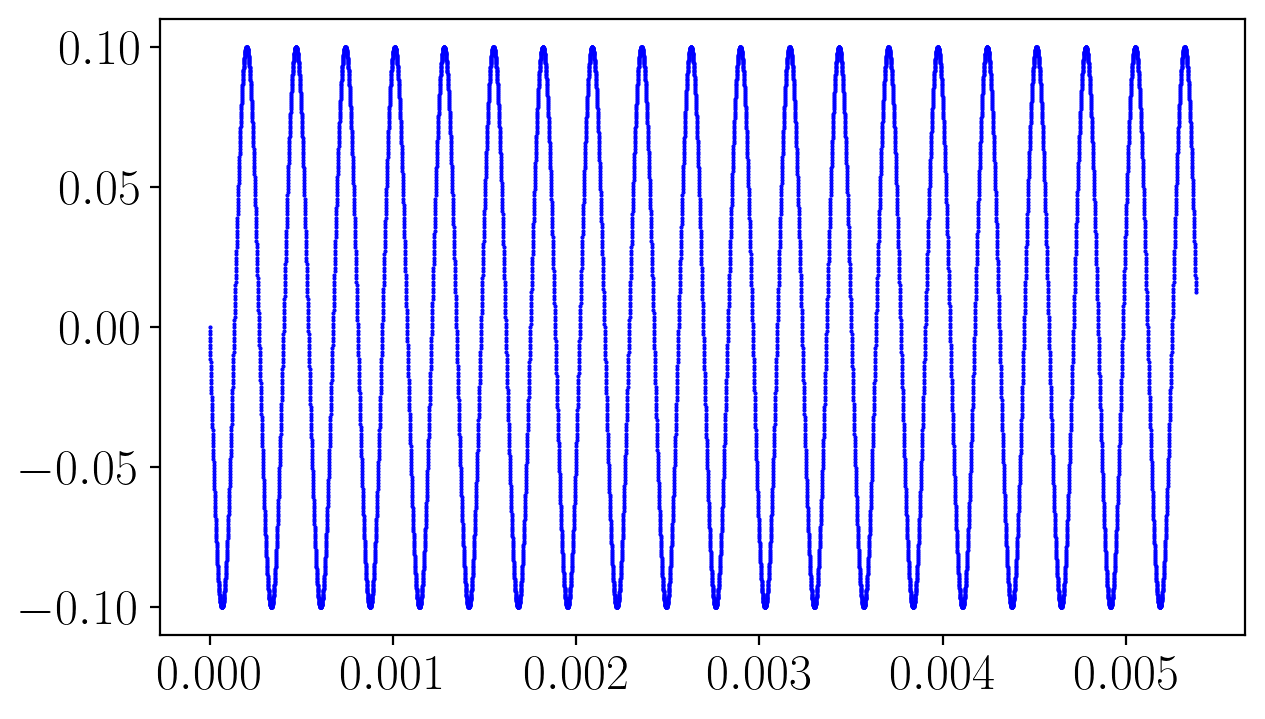

In [5]:
plot_forcing = ek_mag * np.sin(coriolis * ω_force * np.arange(0,stop_sim_time,max_timestep))
fig,(ax) = plt.subplots(1,1, figsize=(7,4))
ax.plot(np.arange(0,stop_sim_time,max_timestep)/(60*60*24),plot_forcing, 'bo', markersize=0.5)
plt.show()

In [6]:
## basis
dtype = np.complex128
coords  = d3.PolarCoordinates('θ', 'r')
dist    = d3.Distributor(coords, dtype=dtype)
basis   = d3.AnnulusBasis(coords, shape = (Nθ, Nr), radii = (Ri,Ro), dealias = 2, dtype = dtype)


In [7]:
## fields
ψ    = dist.Field(name='ψ', bases=basis)
tau1 = dist.Field(name='tau1', bases=basis.outer_edge)
tau2 = dist.Field(name='tau2', bases=basis.outer_edge)
t    = dist.Field(name='t')

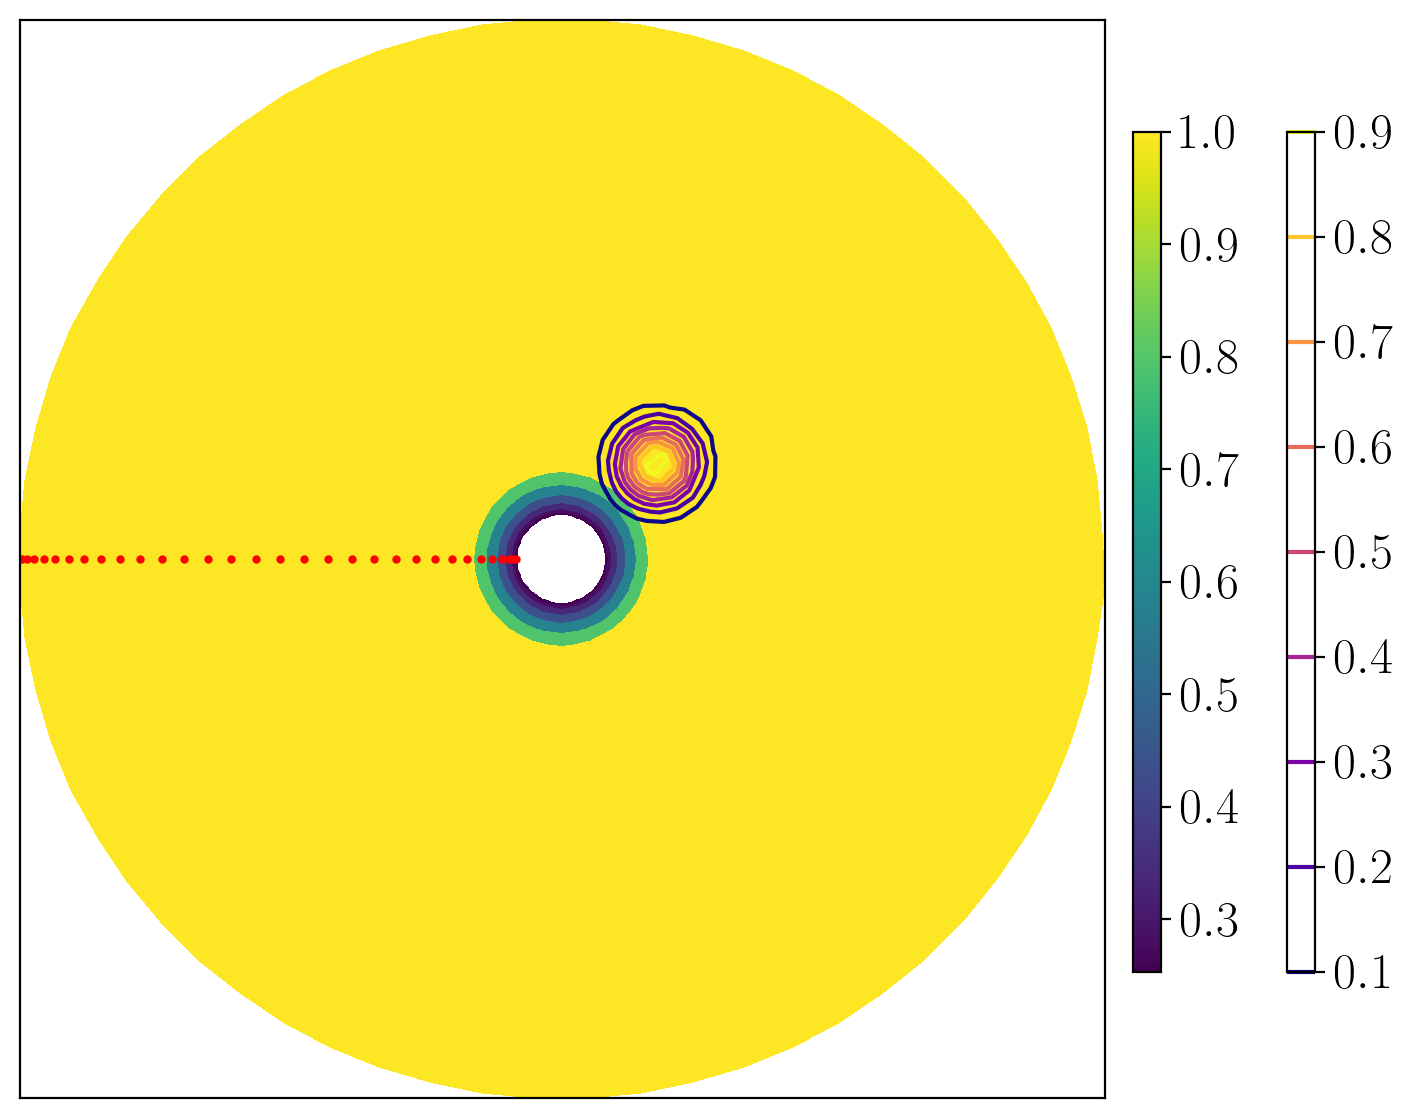

In [8]:
## substitutions
θ, r       = dist.local_grids(basis)
lift_basis = basis.derivative_basis(2)
tau_terms  = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)

er = dist.VectorField(coords, bases=basis.radial_basis)
er['g'][1] = 1

R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# bathymetry (defined here as 1D not 2D)
hisland = r**(2*α) 
hisland[hisland>1] = 1
hinv = dist.Field(name='hinv',bases=basis.radial_basis )## note that you run into problems if you give hinv a theta basis if it does not in actuality vary with theta
hinv['g'] = hisland**(-1)

# define zeta
ζ = d3.div(hinv*d3.grad(ψ))

m_func = lambda m: abs(m)
abs_m = lambda A: abs_m_cls(A, coords['θ']) #note this implements the Dirichlet-to-Neumann BC


## forcing
r0 = 1.5; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));

wek_spatial      = dist.Field(bases=basis)
wek_spatial['g'] = ek_mag * gaussian 
wek              = wek_spatial * np.cos(ω_force * coriolis * t)

## plot fields ##
fig,(ax) = plt.subplots(1,1, figsize=(7,7))
c=ax.pcolormesh(x,y,(R*0+1)*(1/hinv['g'].real))
ax.plot(-r,0,'ro', markersize=2)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
f = ax.contour(x,y,gaussian, levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], cmap='plasma')
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.set_xticks([]);ax.set_yticks([])
cax = fig.add_axes([1.03, 0.2, 0.02, 0.6])
cbar=plt.colorbar(f,cax = cax,orientation='vertical',shrink = 0.5)
plt.show()

In [9]:
## problem
problem = d3.IVP([ψ, tau1, tau2], time=t, namespace=locals())
problem.add_equation("dt(ζ) + coriolis*(skew(grad(ψ))@grad(hinv)) +tau_terms = -κ*hinv*div(hinv*grad(ψ)) + wek")
problem.add_equation("ψ(r=Ri)=0") #inner BC
# problem.add_equation("ψ(r=Ro)=0") #inner BC
# problem.add_equation("(er@grad(ψ)(r=Ro)) + abs_m(ψ)(r=Ro) / Ro = 0") #outer BC
problem.add_equation("(er@grad(ψ))(r=Ro) + abs_m(ψ(r=Ro)) / Ro = 0") #outer BC


{'LHS': Add(interp(Dot(<Field 4531928144>, Grad(<Field 5276850976>)), r=6), Mul(0.16666666666666666, abs_m(interp(<Field 5276850976>, r=6)))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': 0,
 'L': Add(interp(Dot(<Field 4531928144>, Grad(<Field 5276850976>)), r=6), Mul(0.16666666666666666, abs_m(interp(<Field 5276850976>, r=6)))),
 'F': <Field 5275131520>,
 'domain': <dedalus.core.domain.Domain at 0x13a8656a0>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [10]:
## solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-08-02 15:29:37,778 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 18s, Rate: 3.4e+00/s
2024-08-02 15:29:38,815 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 1s, Remaining: 11s, Rate: 5.3e+00/s
2024-08-02 15:29:40,019 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 3s, Remaining: 9s, Rate: 5.5e+00/s
2024-08-02 15:29:41,295 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 4s, Remaining: 8s, Rate: 5.5e+00/s
2024-08-02 15:29:42,505 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 5s, Remaining: 6s, Rate: 5.6e+00/s
2024-08-02 15:29:43,718 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 6s, Remaining: 5s, Rate: 5.6e+00/s
2024-08-02 15:29:44,925 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 7s, Remaining: 4s, Rate: 5.6e+00/s
2024-08-02 15:29:46,145 subsystems 0/1 INFO :: Building subproblem mat

In [11]:
# Analysis
snapshots = solver.evaluator.add_file_handler('dirichletneumann_hf_snapshots', sim_dt=1)
snapshots.add_task(ψ, name='streamfunction')

In [12]:
%%time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = max_timestep
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-08-02 15:29:48,723 __main__ 0/1 INFO :: Starting main loop
2024-08-02 15:29:48,882 __main__ 0/1 INFO :: Iteration=1, Time=4.654211e-02, dt=4.654211e-02
2024-08-02 15:29:49,058 __main__ 0/1 INFO :: Iteration=11, Time=5.119632e-01, dt=4.654211e-02
2024-08-02 15:29:49,226 __main__ 0/1 INFO :: Iteration=21, Time=9.773844e-01, dt=4.654211e-02
2024-08-02 15:29:49,401 __main__ 0/1 INFO :: Iteration=31, Time=1.442806e+00, dt=4.654211e-02
2024-08-02 15:29:49,569 __main__ 0/1 INFO :: Iteration=41, Time=1.908227e+00, dt=4.654211e-02
2024-08-02 15:29:49,742 __main__ 0/1 INFO :: Iteration=51, Time=2.373648e+00, dt=4.654211e-02
2024-08-02 15:29:49,913 __main__ 0/1 INFO :: Iteration=61, Time=2.839069e+00, dt=4.654211e-02
2024-08-02 15:29:50,086 __main__ 0/1 INFO :: Iteration=71, Time=3.304490e+00, dt=4.654211e-02
2024-08-02 15:29:50,258 __main__ 0/1 INFO :: Iteration=81, Time=3.769911e+00, dt=4.654211e-02
2024-08-02 15:29:50,435 __main__ 0/1 INFO :: Iteration=91, Time=4.235332e+00, dt=4.654211e-

In [13]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'streamfunction'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

# Create figure
with h5py.File('dirichletneumann_hf_snapshots/dirichletneumann_hf_snapshots_s1.h5', mode='r') as file:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Plot writes
    dset = file['tasks'][task]
    theta = dset.dims[1][0][:]
    r = dset.dims[2][0][:]
    R,THETA = np.meshgrid(r,theta)
    x = R*np.cos(THETA); y=R*np.sin(THETA)
    data = np.real(dset[0])
    # clim = 0.04
    clim = np.max(np.abs(dset[:]))
    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))
    surf = ax.pcolormesh(x, y, data, cmap = cmap,clim = (-clim,clim))
    # ax.axis('off')

    def animate(i):
        data = dset[i]
        surf.set_array(np.real(data).ravel())
        return [surf]
    
    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2024-08-02 15:32:44,989 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-08-02 15:32:44,993 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/tmpsqte6z5_/temp.m4v


Looks like this settles into a mode 3 wave as expected...maybe let's try a lower frequency?

## low frequency

In [28]:
## parameters 
Ri          = 0.5
Ro          = 6
Nθ          = 64;
Nr          = 32;
ω_force     = -0.2
κ           = 1e-3
ek_mag      = 0.1
Hmin_island = 0.25;
coriolis    = 1 # we nondimensionalize by f
α           = np.log(Hmin_island)/(2*np.log(Ri)); ## = 1

In [29]:
## time evolution
timestepper    = d3.RK222
forcing_freq   = ω_force * coriolis
forcing_period = np.abs(1/forcing_freq) * 2 * np.pi
max_timestep   = forcing_period/500 # timestep = max_timestep in this implementation
stop_sim_time  = int(forcing_period * 20) 

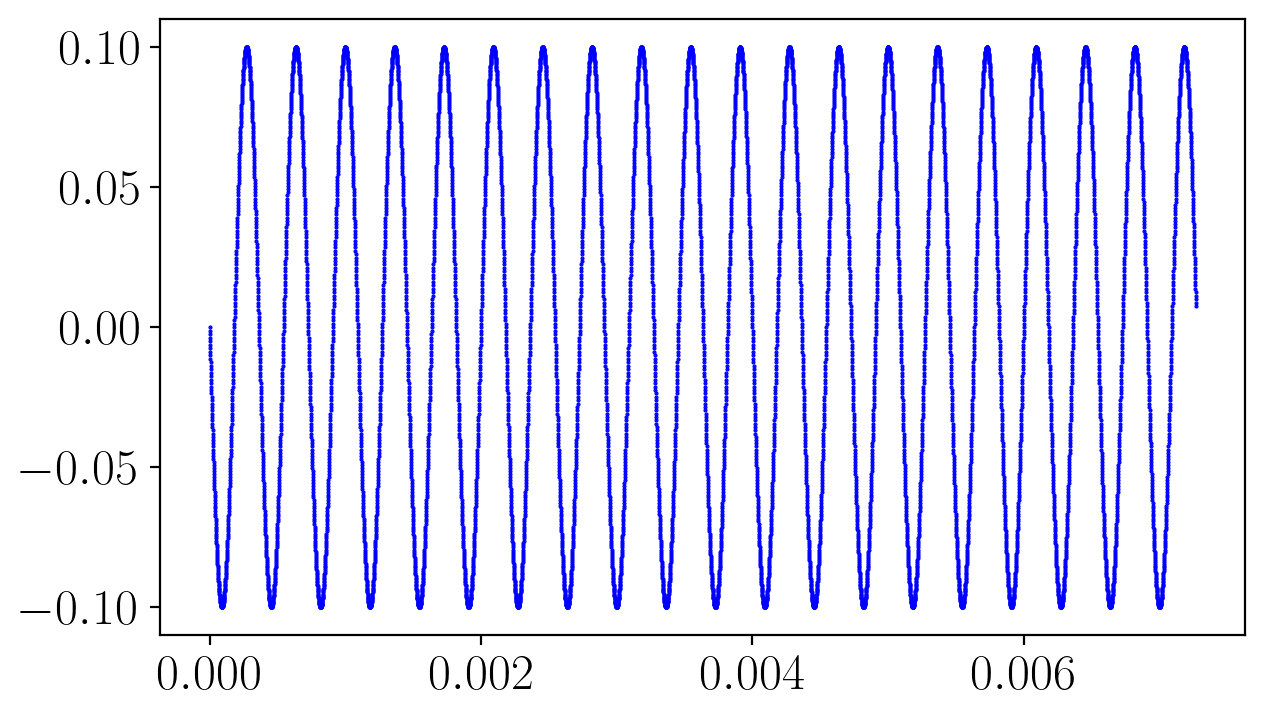

In [30]:
plot_forcing = ek_mag * np.sin(coriolis * ω_force * np.arange(0,stop_sim_time,max_timestep))
fig,(ax) = plt.subplots(1,1, figsize=(7,4))
ax.plot(np.arange(0,stop_sim_time,max_timestep)/(60*60*24),plot_forcing, 'bo', markersize=0.5)
plt.show()

In [31]:
## basis
dtype = np.complex128
coords  = d3.PolarCoordinates('θ', 'r')
dist    = d3.Distributor(coords, dtype=dtype)
basis   = d3.AnnulusBasis(coords, shape = (Nθ, Nr), radii = (Ri,Ro), dealias = 2, dtype = dtype)


In [32]:
## fields
ψ    = dist.Field(name='ψ', bases=basis)
tau1 = dist.Field(name='tau1', bases=basis.outer_edge)
tau2 = dist.Field(name='tau2', bases=basis.outer_edge)
t    = dist.Field(name='t')

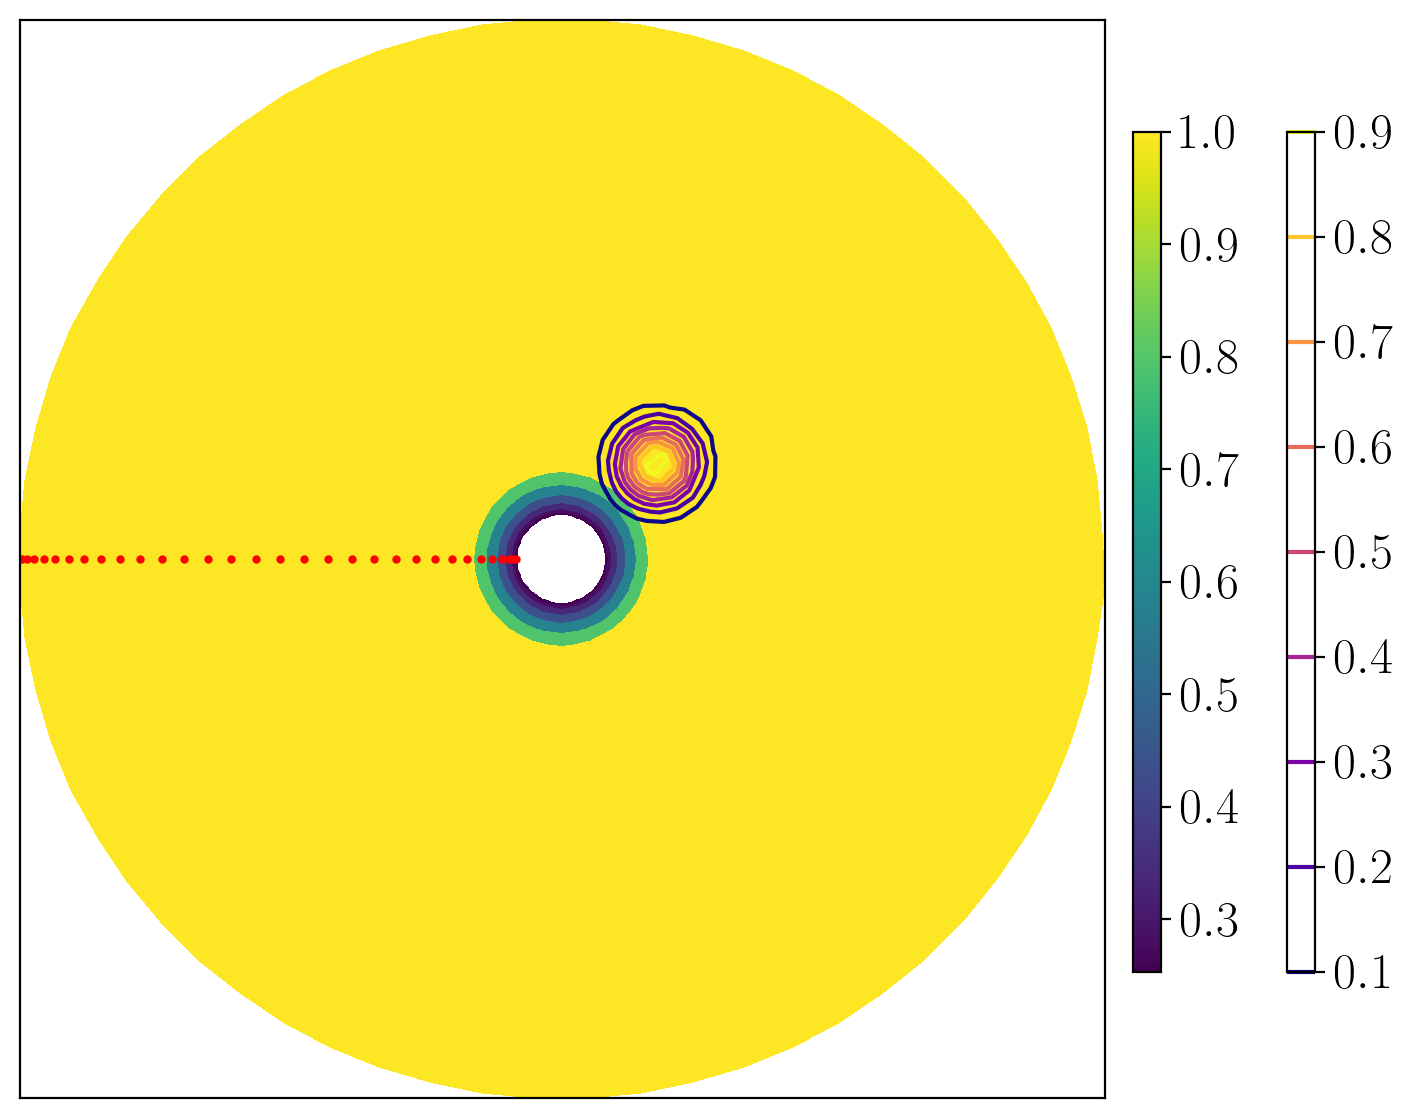

In [33]:
## substitutions
θ, r       = dist.local_grids(basis)
lift_basis = basis.derivative_basis(2)
tau_terms  = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)

er = dist.VectorField(coords, bases=basis.radial_basis)
er['g'][1] = 1

R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# bathymetry (defined here as 1D not 2D)
hisland = r**(2*α) 
hisland[hisland>1] = 1
hinv = dist.Field(name='hinv',bases=basis.radial_basis )## note that you run into problems if you give hinv a theta basis if it does not in actuality vary with theta
hinv['g'] = hisland**(-1)

# define zeta
ζ = d3.div(hinv*d3.grad(ψ))

m_func = lambda m: abs(m)
abs_m = lambda A: abs_m_cls(A, coords['θ']) #note this implements the Dirichlet-to-Neumann BC


## forcing
r0 = 1.5; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));

wek_spatial      = dist.Field(bases=basis)
wek_spatial['g'] = ek_mag * gaussian 
wek              = wek_spatial * np.cos(ω_force * coriolis * t)

## plot fields ##
fig,(ax) = plt.subplots(1,1, figsize=(7,7))
c=ax.pcolormesh(x,y,(R*0+1)*(1/hinv['g'].real))
ax.plot(-r,0,'ro', markersize=2)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
f = ax.contour(x,y,gaussian, levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], cmap='plasma')
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.set_xticks([]);ax.set_yticks([])
cax = fig.add_axes([1.03, 0.2, 0.02, 0.6])
cbar=plt.colorbar(f,cax = cax,orientation='vertical',shrink = 0.5)
plt.show()

In [34]:
## problem
problem = d3.IVP([ψ, tau1, tau2], time=t, namespace=locals())
problem.add_equation("dt(ζ) + coriolis*(skew(grad(ψ))@grad(hinv)) +tau_terms = -κ*hinv*div(hinv*grad(ψ)) + wek")
problem.add_equation("ψ(r=Ri)=0") #inner BC
problem.add_equation("(er@grad(ψ))(r=Ro) + abs_m(ψ(r=Ro)) / Ro = 0") #outer BC


{'LHS': Add(interp(Dot(<Field 5278450464>, Grad(<Field 5275790960>)), r=6), Mul(0.16666666666666666, abs_m(interp(<Field 5275790960>, r=6)))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': 0,
 'L': Add(interp(Dot(<Field 5278450464>, Grad(<Field 5275790960>)), r=6), Mul(0.16666666666666666, abs_m(interp(<Field 5275790960>, r=6)))),
 'F': <Field 5288791744>,
 'domain': <dedalus.core.domain.Domain at 0x13a760bf0>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False,  True])}

In [35]:
## solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-08-02 15:42:32,489 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 18s, Rate: 3.5e+00/s
2024-08-02 15:42:33,511 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 1s, Remaining: 11s, Rate: 5.3e+00/s
2024-08-02 15:42:34,719 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 3s, Remaining: 9s, Rate: 5.6e+00/s
2024-08-02 15:42:35,940 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 4s, Remaining: 8s, Rate: 5.6e+00/s
2024-08-02 15:42:37,134 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 5s, Remaining: 6s, Rate: 5.7e+00/s
2024-08-02 15:42:38,352 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 6s, Remaining: 5s, Rate: 5.7e+00/s
2024-08-02 15:42:39,612 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 7s, Remaining: 4s, Rate: 5.7e+00/s
2024-08-02 15:42:41,110 subsystems 0/1 INFO :: Building subproblem mat

In [36]:
# Analysis
snapshots = solver.evaluator.add_file_handler('dirichletneumann_lf_snapshots', sim_dt=1)
snapshots.add_task(ψ, name='streamfunction')

In [37]:
%%time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = max_timestep
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-08-02 15:42:43,770 __main__ 0/1 INFO :: Starting main loop
2024-08-02 15:42:43,857 __main__ 0/1 INFO :: Iteration=1, Time=6.283185e-02, dt=6.283185e-02
2024-08-02 15:42:44,030 __main__ 0/1 INFO :: Iteration=11, Time=6.911504e-01, dt=6.283185e-02
2024-08-02 15:42:44,202 __main__ 0/1 INFO :: Iteration=21, Time=1.319469e+00, dt=6.283185e-02
2024-08-02 15:42:44,372 __main__ 0/1 INFO :: Iteration=31, Time=1.947787e+00, dt=6.283185e-02
2024-08-02 15:42:44,545 __main__ 0/1 INFO :: Iteration=41, Time=2.576106e+00, dt=6.283185e-02
2024-08-02 15:42:44,717 __main__ 0/1 INFO :: Iteration=51, Time=3.204425e+00, dt=6.283185e-02
2024-08-02 15:42:44,890 __main__ 0/1 INFO :: Iteration=61, Time=3.832743e+00, dt=6.283185e-02
2024-08-02 15:42:45,061 __main__ 0/1 INFO :: Iteration=71, Time=4.461062e+00, dt=6.283185e-02
2024-08-02 15:42:45,232 __main__ 0/1 INFO :: Iteration=81, Time=5.089380e+00, dt=6.283185e-02
2024-08-02 15:42:45,399 __main__ 0/1 INFO :: Iteration=91, Time=5.717699e+00, dt=6.283185e-

In [38]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'streamfunction'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

# Create figure
with h5py.File('dirichletneumann_lf_snapshots/dirichletneumann_lf_snapshots_s1.h5', mode='r') as file:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Plot writes
    dset = file['tasks'][task]
    theta = dset.dims[1][0][:]
    r = dset.dims[2][0][:]
    R,THETA = np.meshgrid(r,theta)
    x = R*np.cos(THETA); y=R*np.sin(THETA)
    data = np.real(dset[0])
    # clim = 0.04
    clim = np.max(np.abs(dset[:]))
    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))
    surf = ax.pcolormesh(x, y, data, cmap = cmap,clim = (-clim,clim))
    # ax.axis('off')

    def animate(i):
        data = dset[i]
        surf.set_array(np.real(data).ravel())
        return [surf]
    
    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2024-08-02 15:45:34,652 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-08-02 15:45:34,653 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/tmp9vca_rnu/temp.m4v
